In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/elsevier/Bert-NER'
%cd $path
import utils_train as ut
import utils_annotate
import random
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import net
from trainer import train
from transformers import BertForMaskedLM, BertTokenizer
!pip install highlight-text
import matplotlib.pyplot as plt
from highlight_text import HighlightText
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/elsevier/Bert-NER


In [2]:
CLASSES = {'MATERIAL': 1,
           'MLIP': 2,
           'PROPERTY': 3,
           'SIMULATION': 4,
           'VALUE': 5,
           'APPL': 6,
           'O': 0}
N_DATA = 0  # 0 is all
N_TEST = 3
BATCH_SIZE = 1
SEED = 32
MAX_LENGTH = 512
CLASS_WEIGHTS = [0.3, 1., 1., 0.5, 1., 1., 1.]
LEARNING_RATE = 0.0001
N_EPOCHS = 6

In [3]:
ut.seed_everything(SEED)

In [4]:
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=MAX_LENGTH)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')
model = net.NERBERTModel(modelBERT.base_model, output_size=len(CLASSES)+1)

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [5]:
data = utils_annotate.combine_records('individual_ner')
utils_annotate.json_train_test('train_test_data', data, N_TEST, shuffle=True)
print(f'Number of training data: {len(data) - N_TEST}')
print(f'Number of test data: {N_TEST}')

Number of training data: 59
Number of test data: 3


Epoch 1
Mean training loss: 0.6418
Mean training accuracy: 0.8502
Mean training precision: 0.6469
Mean training recall: 0.6978
Mean training f1: 0.6450
Mean test accuracy: 0.9181
Mean test precision: 0.7533
Mean test recall: 0.8014
Mean test f1: 0.7738


Epoch 2
Mean training loss: 0.2136
Mean training accuracy: 0.9388
Mean training precision: 0.8378
Mean training recall: 0.8732
Mean training f1: 0.8407
Mean test accuracy: 0.9285
Mean test precision: 0.8329
Mean test recall: 0.9125
Mean test f1: 0.8459


Epoch 3
Mean training loss: 0.1153
Mean training accuracy: 0.9686
Mean training precision: 0.9203
Mean training recall: 0.9498
Mean training f1: 0.9277
Mean test accuracy: 0.9272
Mean test precision: 0.8710
Mean test recall: 0.8967
Mean test f1: 0.8731


Epoch 4
Mean training loss: 0.0800
Mean training accuracy: 0.9780
Mean training precision: 0.9461
Mean training recall: 0.9603
Mean training f1: 0.9488
Mean test accuracy: 0.9311
Mean test precision: 0.9476
Mean test recall: 0.8631
Mea

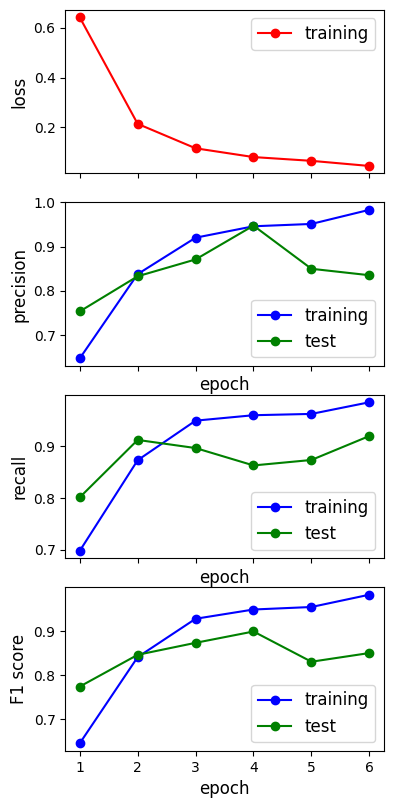

In [6]:
model, train_losses, train_accuracies, precision_test, recall_test, f1_test, test_accuracies, pred_classes, true_classes, pred_all, true_all, data_list = train(model, tokenizerBERT,
   'train_test_data/data_train.json', 'train_test_data/data_test.json', CLASSES, N_DATA, BATCH_SIZE, SEED, MAX_LENGTH, CLASS_WEIGHTS, LEARNING_RATE, N_EPOCHS, plot=True, save_model=True)

# Show prediction

In [7]:
# sample_id = 2
# word_list = data_list[sample_id]['words']
# labels = true_all
# predictions = pred_all[sample_id, :, :].max(dim=0)[1]
# colors = ['black', 'red', 'blue', 'green', 'magenta', 'cyan', 'darkorange']
# real_preds = predictions[:len(word_list)]
# word_list_marked = ['<' + w + '>' for w in word_list]
# markers = [{"color": colors[i]} for i in real_preds]
# j = 0
# for i in range(len(word_list)):
#     if (i + 1) % 15 == 0:
#         word_list_marked.insert(i + j, '\n')
#         j += 1
# fig, ax = plt.subplots()
# ax.set_axis_off()
# HighlightText(x=0., y=1, s='<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <SIMULATION>, <VALUE>, <APPL>',
#               highlight_textprops=[{"color": c} for c in colors], ax=ax)
# HighlightText(x=0., y=0.9, s=' '.join(word_list_marked),
#               highlight_textprops=markers, ax=ax)
# plt.show()